# Introduction

One of the questions we make to the dataset is the likelihood between neighborhoods and other aglomerative features. We will take the snow volume picked in each travel and agglomerate first by neighborhood.

We will treat each set of volume picked up as a time series. Later, we will compare each time series by applying a clustering algorithm with Dynamic Time Warping (DTW) to accomodate time series with different sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyts

plt.style.use("ggplot")


In [4]:
transaction = pd.read_csv("../data/transaction/transactions_deneigement_saison_2016-2017.csv")
transaction["DateChargement"] = pd.to_datetime(transaction["DateChargement"])
transaction["DateDechargement"] = pd.to_datetime(transaction["DateDechargement"])
transaction = transaction[transaction["volume"].notna()]
# transaction = transaction[transaction["Idenfiantsecteur"].notna()] # Remove operations from partners and private operations
transaction.head()


C:\Users\paulo\AppData\Local\Temp\ipykernel_36756\1660471309.py:1: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction = pd.read_csv("../data/transaction/transactions_deneigement_saison_2016-2017.csv")


,TransactionID,DateChargement,Idenfiantsecteur,NomSecteur,IdentifiantArrondissement,ArrondissementCode,Arrondissement,IdentifiantDepot,NomDepot,DateDechargement,volume,TypeTransaction,IdentifiantContrat,NuméroContrat
0,375501,2016-12-13 10:45:02,104.0,SLA-353,13,SLA,Saint-Laurent,49,Thimens (SLA),2016-12-13 10:53:27,59.64,AUT,354.0,SLA-353
1,375636,2016-12-13 10:58:44,95.0,MTN-303,14,MTN,Montréal-Nord,58,St-Michel - Charland (VSP),2016-12-13 11:06:26,28.76,AUT,327.0,MTN-303
2,375657,2016-12-13 11:01:01,95.0,MTN-303,14,MTN,Montréal-Nord,58,St-Michel - Charland (VSP),2016-12-13 11:08:59,31.34,AUT,327.0,MTN-303
3,375778,2016-12-13 11:11:01,104.0,SLA-353,13,SLA,Saint-Laurent,49,Thimens (SLA),2016-12-13 11:19:52,59.64,AUT,354.0,SLA-353
4,375901,2016-12-13 11:26:03,95.0,MTN-303,14,MTN,Montréal-Nord,58,St-Michel - Charland (VSP),2016-12-13 11:33:39,28.76,AUT,327.0,MTN-303


In [5]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338809 entries, 0 to 338808
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   TransactionID              338809 non-null  int64         
 1   DateChargement             338809 non-null  datetime64[ns]
 2   Idenfiantsecteur           319642 non-null  float64       
 3   NomSecteur                 319642 non-null  object        
 4   IdentifiantArrondissement  338809 non-null  int64         
 5   ArrondissementCode         338809 non-null  object        
 6   Arrondissement             338809 non-null  object        
 7   IdentifiantDepot           338809 non-null  int64         
 8   NomDepot                   338809 non-null  object        
 9   DateDechargement           338809 non-null  datetime64[ns]
 10  volume                     338809 non-null  float64       
 11  TypeTransaction            338809 non-null  object  

# Preparing Data

In [8]:
transaction = transaction.sort_values(by="DateDechargement")
print(transaction.shape)
transaction.head()

(338809, 14)


,TransactionID,DateChargement,Idenfiantsecteur,NomSecteur,IdentifiantArrondissement,ArrondissementCode,Arrondissement,IdentifiantDepot,NomDepot,DateDechargement,volume,TypeTransaction,IdentifiantContrat,NuméroContrat
323782,474030,2016-12-01 00:00:00,NaN,NaN,13,SLA,Saint-Laurent,49,Thimens (SLA),2016-12-01 00:00:00,25.0,BARCODE,NaN,NaN
319691,373242,2016-12-09 18:18:24,NaN,NaN,19,S-O,Sud-Ouest,42,Butler (S-O),2016-12-09 18:18:24,55.0,BARCODE,NaN,NaN
319692,373243,2016-12-09 18:27:02,NaN,NaN,19,S-O,Sud-Ouest,42,Butler (S-O),2016-12-09 18:27:02,55.0,BARCODE,NaN,NaN
319694,373245,2016-12-09 20:37:26,NaN,NaN,13,SLA,Saint-Laurent,49,Thimens (SLA),2016-12-09 20:37:26,55.0,BARCODE,NaN,NaN
319693,373244,2016-12-09 20:48:16,NaN,NaN,13,SLA,Saint-Laurent,50,Sartelon (SLA),2016-12-09 20:48:16,55.0,BARCODE,NaN,NaN


In [9]:
transaction["Arrondissement"].unique()

array(['Saint-Laurent', 'Sud-Ouest', 'Ahuntsic / Cartierville',
       'R.D.P. /  P.A.T.', 'Mercier / Hochelaga / Maisonneuve',
       'Villeray / St-Michel / Parc-Extension', 'Anjou', 'Lachine',
       'Verdun', 'Ville-Marie', 'Montréal-Nord', 'LaSalle',
       'Rosemont / Petite-Patrie', 'Saint-Léonard', 'Plateau Mont-Royal',
       'Côte-des-Neiges / Notre-Dame-de-Grâce', 'Outremont',
       'Pierrefonds / Roxboro', "L'Île Bizard / Sainte-Geneviève"],
      dtype=object)

In [10]:
aggregation_key = ["Arrondissement", "TypeTransaction"]
# aggregation_key = "Idenfiantsecteur"
# aggregation_key = "NomSecteur"

min_length = 0 
# below 200 there are some mistakes which makes the whole series have a single value(60.1) for some reason
# maybe because either the trucks recovered a lot of snow on those days or they are errors.

volume_series = transaction.groupby(by=aggregation_key)["volume"].apply(np.asarray)
volume_series = volume_series[volume_series.apply(len) > min_length]

volume_series_period = transaction.groupby(by=aggregation_key)["DateDechargement"].apply(np.asarray)
volume_series_period = volume_series_period[volume_series_period.apply(len) > min_length]

volume_series_length = volume_series.apply(len)


In [11]:
display(volume_series)

Arrondissement                         TypeTransaction
Ahuntsic / Cartierville                AUT                [65.57, 32.13, 33.11, 53.41, 36.38, 32.13, 33....
                                       BARCODE            [55.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....
                                       N-AUT              [52.04, 29.96, 52.04, 52.04, 47.06, 52.04, 52....
Anjou                                  AUT                [58.86, 74.12, 56.32, 68.03, 30.04, 38.62, 70....
                                       BARCODE            [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....
                                       N-AUT              [53.02, 31.88, 33.52, 21.03, 31.82, 31.89, 30....
Côte-des-Neiges / Notre-Dame-de-Grâce  AUT                [32.72, 33.31, 31.95, 32.98, 31.89, 55.84, 32....
                                       N-AUT              [57.02, 57.02, 57.02, 68.19, 47.86, 39.49, 29....
L'Île Bizard / Sainte-Geneviève        AUT                [31.67, 50.12, 30.83, 3

In [12]:
transaction.groupby(by=aggregation_key)["volume"].describe()

count       mean  \
Arrondissement                        TypeTransaction                       
Ahuntsic / Cartierville               AUT              29704.0  43.861891   
                                      BARCODE             43.0  30.581395   
                                      N-AUT             1014.0  42.528491   
Anjou                                 AUT              15692.0  41.241554   
                                      BARCODE           3023.0  35.932848   
                                      N-AUT              761.0  32.113627   
Côte-des-Neiges / Notre-Dame-de-Grâce AUT              16140.0  45.378512   
                                      N-AUT             1341.0  41.042110   
L'Île Bizard / Sainte-Geneviève       AUT               1288.0  30.922492   
                                      N-AUT              741.0  24.531026   
LaSalle                               AUT              21691.0  33.539400   
                                      BARCODE            599.0  33.188648   
                                      N-AUT              590.0  35.102695   
Lachine                               AUT              13227.0  28.780520   
                                      BARCODE           1375.0  41.516364   
                                      N-AUT              781.0  28.197964   
Mercier / Hochelaga / Maisonneuve     AUT              21358.0  59.677522   
                                      N-AUT              658.0  60.933587   
Montréal-Nord                         AUT              16576.0  38.160752   
                                      N-AUT             1751.0  26.152581   
Outremont                             AUT               2833.0  60.233678   
                                      N-AUT              164.0  62.340366   
Pierrefonds / Roxboro                 AUT               4726.0  28.251621   
                                      BARCODE            383.0  34.947781   
                                      N-AUT              818.0  25.377555   
Plateau Mont-Royal                    AUT              10900.0  42.660155   
                                      N-AUT              796.0  29.872425   
R.D.P. /  P.A.T.                      AUT              28761.0  49.758054   
                                      BARCODE            209.0  31.698565   
                                      N-AUT             2082.0  40.664131   
Rosemont / Petite-Patrie              AUT              15274.0  62.483514   
                                      N-AUT              432.0  60.848310   
Saint-Laurent                         AUT              20694.0  41.311313   
                                      BARCODE           3427.0  36.346659   
                                      N-AUT             1005.0  42.369254   
Saint-Léonard                         AUT              28093.0  34.514835   
                                      N-AUT             1232.0  34.302119   
Sud-Ouest                             AUT              12159.0  38.392465   
                                      BARCODE              2.0  55.000000   
                                      N-AUT              562.0  35.521762   
Verdun                                AUT               8742.0  31.467236   
                                      BARCODE              2.0  30.000000   
                                      N-AUT             1151.0  28.340982   
Ville-Marie                           AUT              12586.0  38.257028   
                                      N-AUT              784.0  36.670765   
Villeray / St-Michel / Parc-Extension AUT              21626.0  43.907927   
                                      BARCODE          10104.0  33.929137   
                                      N-AUT              909.0  36.227228   

                                                             std    min  \
Arrondissement                        TypeTransaction                     
Ahuntsic / Cartierville               AUT              1

In [13]:
# pd.concat((volume_series_period.apply(len), volume_series_length), axis=1).sort_values(by="volume")
concatenated = pd.concat((volume_series_period.apply(len), volume_series_length), axis=1).sort_index()
print(concatenated.shape)
concatenated

(48, 2)


DateDechargement  \
Arrondissement                        TypeTransaction                     
Ahuntsic / Cartierville               AUT                         29704   
                                      BARCODE                        43   
                                      N-AUT                        1014   
Anjou                                 AUT                         15692   
                                      BARCODE                      3023   
                                      N-AUT                         761   
Côte-des-Neiges / Notre-Dame-de-Grâce AUT                         16140   
                                      N-AUT                        1341   
L'Île Bizard / Sainte-Geneviève       AUT                          1288   
                                      N-AUT                         741   
LaSalle                               AUT                         21691   
                                      BARCODE                       599   
                                      N-AUT                         590   
Lachine                               AUT                         13227   
                                      BARCODE                      1375   
                                      N-AUT                         781   
Mercier / Hochelaga / Maisonneuve     AUT                         21358   
                                      N-AUT                         658   
Montréal-Nord                         AUT                         16576   
                                      N-AUT                        1751   
Outremont                             AUT                          2833   
                                      N-AUT                         164   
Pierrefonds / Roxboro                 AUT                          4726   
                                      BARCODE                       383   
                                      N-AUT                         818   
Plateau Mont-Royal                    AUT                         10900   
                                      N-AUT                         796   
R.D.P. /  P.A.T.                      AUT                         28761   
                                      BARCODE                       209   
                                      N-AUT                        2082   
Rosemont / Petite-Patrie              AUT                         15274   
                                      N-AUT                         432   
Saint-Laurent                         AUT                         20694   
                                      BARCODE                      3427   
                                      N-AUT                        1005   
Saint-Léonard                         AUT                         28093   
                                      N-AUT                        1232   
Sud-Ouest                             AUT                         12159   
                                      BARCODE                         2   
                                      N-AUT                         562   
Verdun                                AUT                          8742   
                                      BARCODE                         2   
                                      N-AUT                        1151   
Ville-Marie                           AUT                         12586   
                                      N-AUT                         784   
Villeray / St-Michel / Parc-Extension AUT                         21626   
                                      BARCODE                     10104   
                                      N-AUT                         909   

                                                       volume  
Arrondissement                        TypeTransaction          
Ahuntsic / Cartierville               AUT               29704  
                                      BARCODE              43  
                                      N-AUT     

## Filtering Signals with Moving Average Filter

In [14]:
kernel_size = 5
filtered_volume_series = volume_series.apply(lambda x: np.convolve(x, np.ones(kernel_size)/kernel_size, mode="same"))

## Secteur Overview

In [15]:
filtered_volume_series

Arrondissement                         TypeTransaction
Ahuntsic / Cartierville                AUT                [26.162, 36.844, 44.120000000000005, 37.432, 3...
                                       BARCODE            [23.0, 29.0, 35.0, 30.0, 30.0, 30.0, 30.0, 30....
                                       N-AUT              [26.808000000000003, 37.21600000000001, 46.628...
Anjou                                  AUT                [37.86000000000001, 51.46600000000001, 57.4740...
                                       BARCODE            [18.0, 24.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....
                                       N-AUT              [23.684, 27.89, 34.254000000000005, 30.0280000...
Côte-des-Neiges / Notre-Dame-de-Grâce  AUT                [19.596000000000004, 26.192, 32.57000000000001...
                                       N-AUT              [34.212, 47.85000000000001, 57.422000000000004...
L'Île Bizard / Sainte-Geneviève        AUT                [22.524, 29.806, 40.858

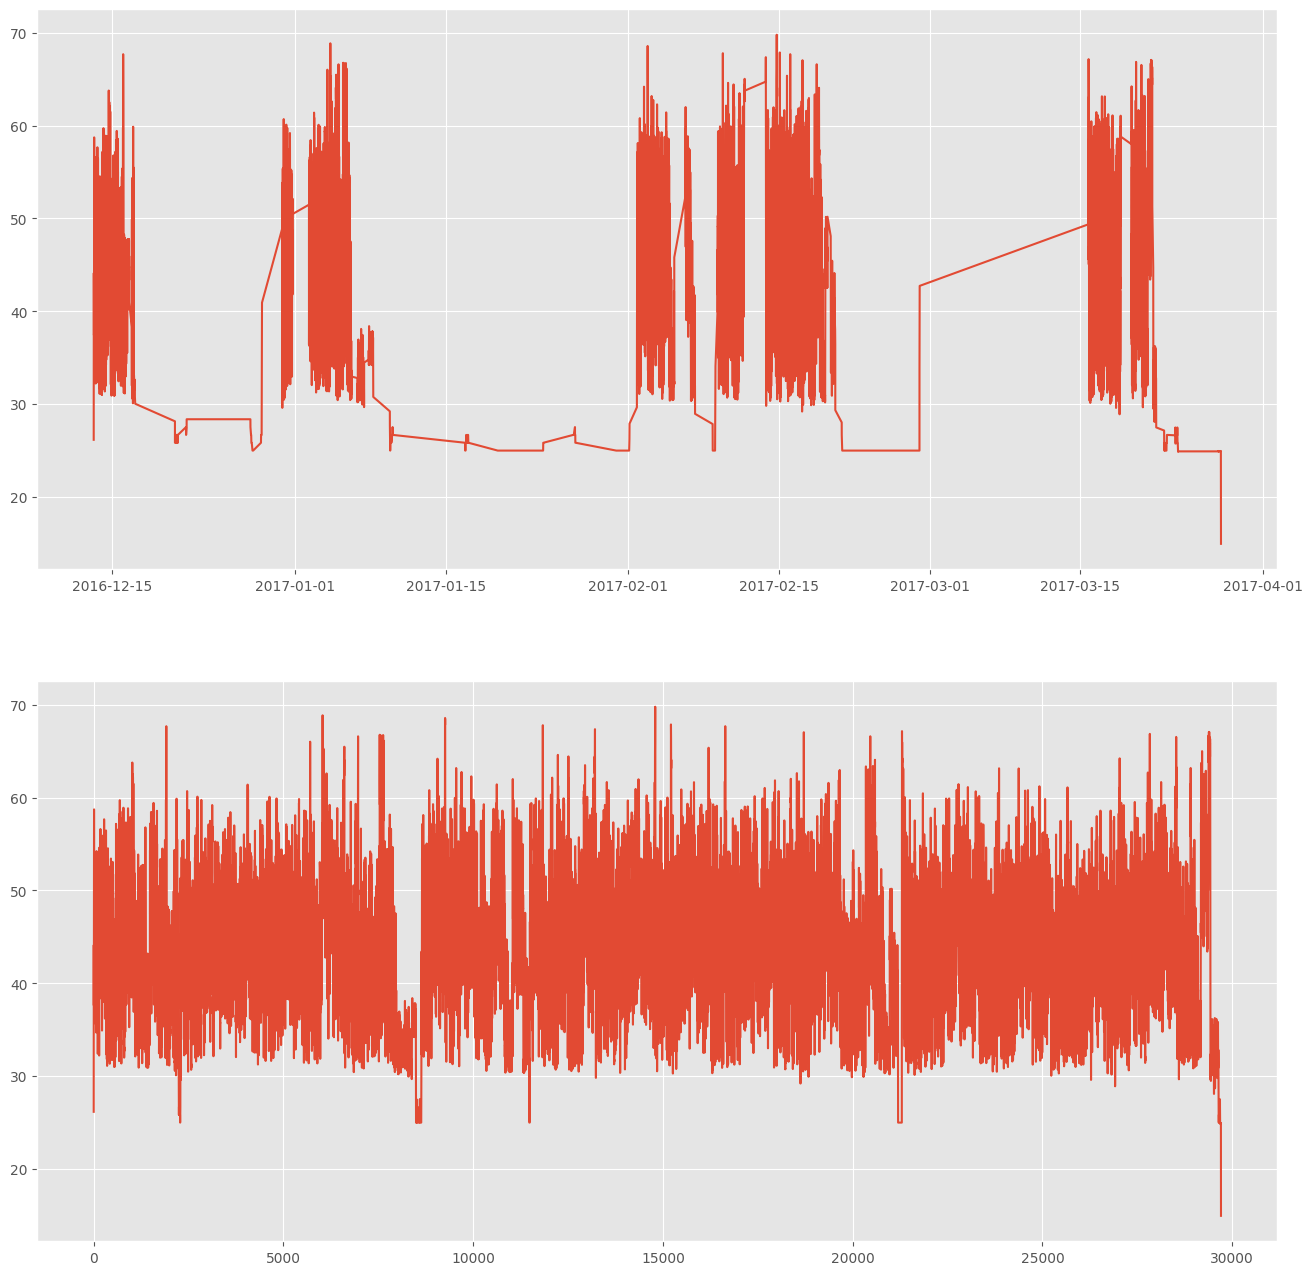

In [17]:
selected_arrondissement = volume_series_length.idxmax()
# plt.figure(figsize=(16, 16))
fig, ax = plt.subplots(2, 1)
fig.set_figheight(16)
fig.set_figwidth(16)
ax[0].plot(volume_series_period.loc[selected_arrondissement], filtered_volume_series.loc[selected_arrondissement], label="period")
ax[1].plot(filtered_volume_series.loc[selected_arrondissement], label="onlyvalues")

In [18]:
filtered_volume_series.loc[selected_arrondissement]

array([26.162, 36.844, 44.12 , ..., 24.916, 19.958, 14.958])

# Clustering Time Series By Neighborhood

In [32]:
volume_series.values[32].shape

(20694,)

In [37]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", n_jobs=-1, max_iter=100)
# filtered_volume_series_list = [x.tolist() for x in list(filtered_volume_series.values)]

print(volume_series)
X_bis = to_time_series_dataset(volume_series)
print(X_bis)
# X_bis = TimeSeriesScalerMeanVariance().fit_transform(X_bis)
# X_bis = TimeSeriesResampler(sz=1024).fit_transform(X_bis)
# X_bis.shape
# kmeans.fit(X_bis)


Arrondissement                         TypeTransaction
Ahuntsic / Cartierville                AUT                [65.57, 32.13, 33.11, 53.41, 36.38, 32.13, 33....
                                       BARCODE            [55.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....
                                       N-AUT              [52.04, 29.96, 52.04, 52.04, 47.06, 52.04, 52....
Anjou                                  AUT                [58.86, 74.12, 56.32, 68.03, 30.04, 38.62, 70....
                                       BARCODE            [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30....
                                       N-AUT              [53.02, 31.88, 33.52, 21.03, 31.82, 31.89, 30....
Côte-des-Neiges / Notre-Dame-de-Grâce  AUT                [32.72, 33.31, 31.95, 32.98, 31.89, 55.84, 32....
                                       N-AUT              [57.02, 57.02, 57.02, 68.19, 47.86, 39.49, 29....
L'Île Bizard / Sainte-Geneviève        AUT                [31.67, 50.12, 30.83, 3

In [167]:
y_predict = kmeans.predict(X_bis)
print(pd.Series(y_predict).value_counts())
print(y_predict)

1    26
0    12
2    10
dtype: int64
[1 0 1 1 1 0 1 1 1 0 0 0 0 2 2 2 2 2 1 0 2 2 1 0 0 1 0 1 0 1 2 2 1 1 1 1 1
 1 1 0 2 1 1 1 1 1 1 1]


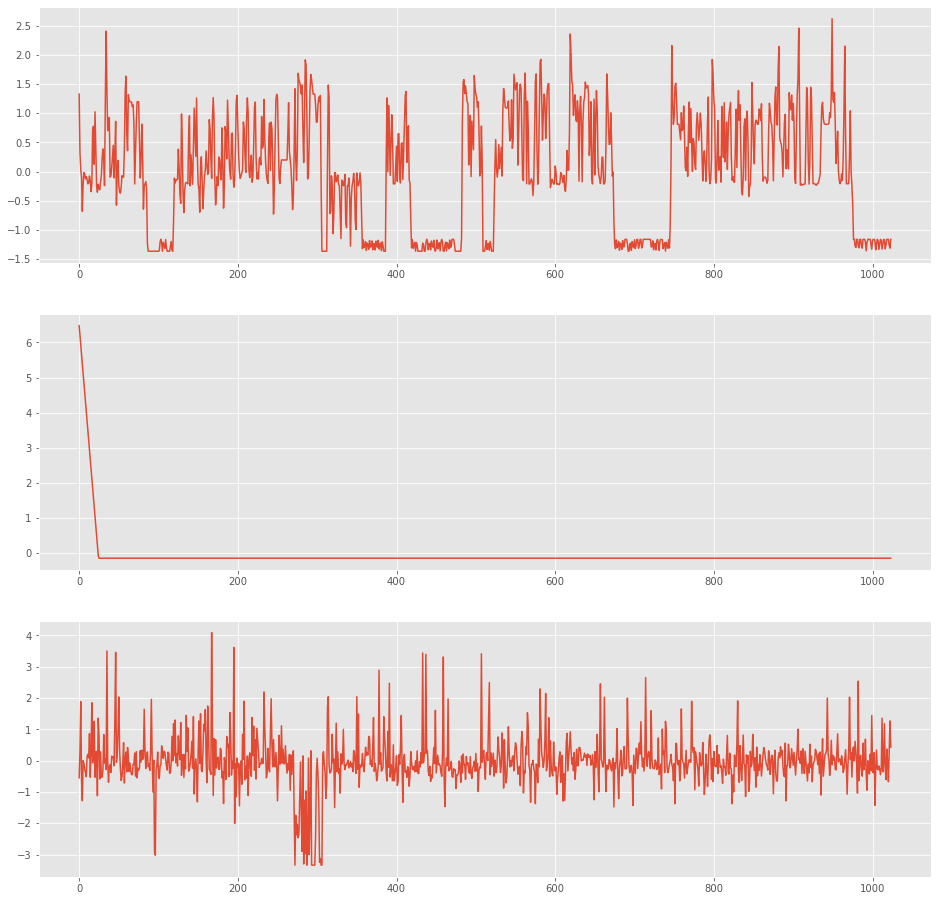

In [169]:
selected_arrondissement = volume_series_length.argmin()
# plt.figure(figsize=(16, 16))
fig, ax = plt.subplots(3, 1)
fig.set_figheight(16)
fig.set_figwidth(16)
ax[0].plot(X_bis[5, :, :])
ax[1].plot(X_bis[1, :, :], label="onlyvalues")
ax[2].plot(X_bis[-8, :, :], label="onlyvalues")

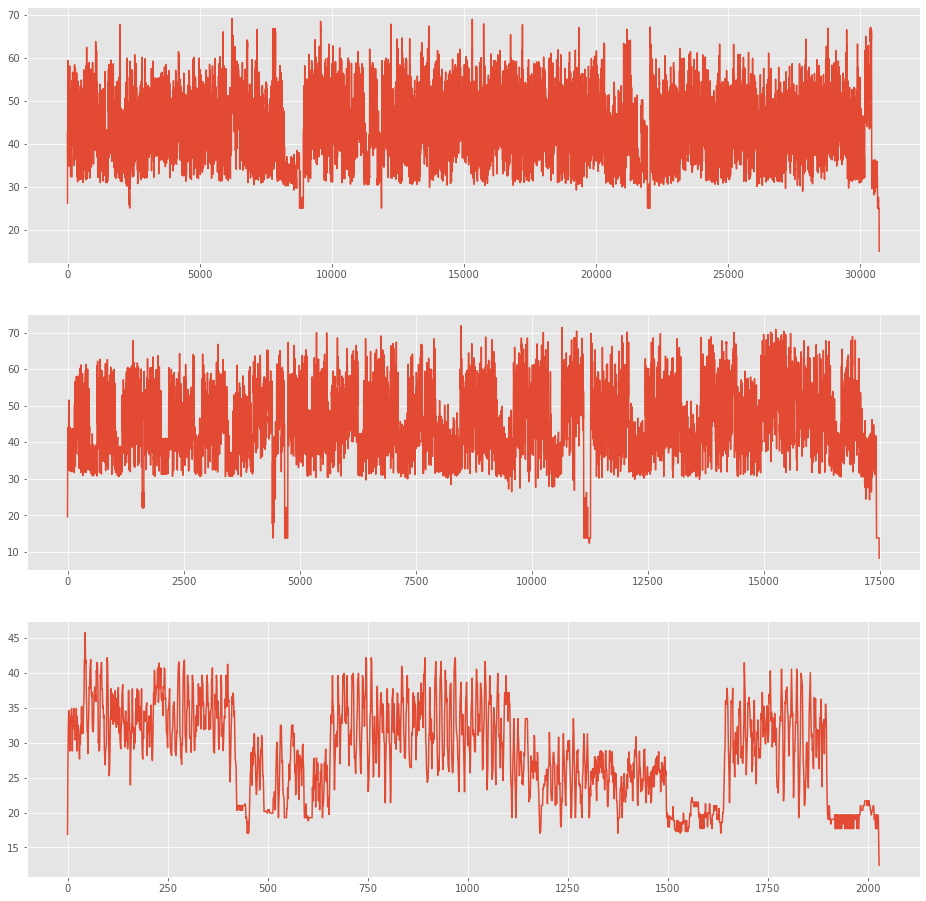

In [149]:
fig, ax = plt.subplots(3, 1)
fig.set_figheight(16)
fig.set_figwidth(16)
ax[0].plot(filtered_volume_series.iloc[0])
ax[1].plot(filtered_volume_series.iloc[2], label="onlyvalues")
ax[2].plot(filtered_volume_series.iloc[3], label="onlyvalues")